The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


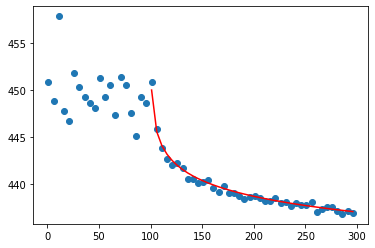

In [430]:
# Simulate different datasets with different error assumptions
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from curve_models import NLLS, NLLS_w, NLLS_rse, power_law
import statsmodels.api as sm

def quadratic(x, a, b):
    return a*x**2 + b

def linearized_power_law(x, a, b):
    return np.exp(b + a*np.log(x))

def simulate_data(a, b, n_steps):
    x = []
    y = []
    x_samples = []
    y_samples = []   
    n_redundant = 1
    burn_in = 100
    for i in range(1, n_steps, 5):
        if i > burn_in:
            x.append(i)
            val = power_law(i-burn_in, a, b)
            y.append(val)
        for j in range(n_redundant):
            x_samples.append(i)
            if i < burn_in:
                noise = np.random.normal(450, 3, 1)[0]
                val = noise
            else:
                noise = np.random.normal(0, 15, 1)[0]/(i**.75)
                val = val+noise
            y_samples.append(val) 
    return x, y, x_samples, y_samples
n_steps = 300
a, b = .0055, 450
x, y, x_samples, y_samples = simulate_data(a, b, n_steps)
plt.scatter(x_samples, y_samples)
plt.plot(x, y, c='r')

[[7.32862534e-08 1.57574315e-04]
 [1.57574315e-04 3.56930866e-01]]
[ 6.13648004 -0.00915586]


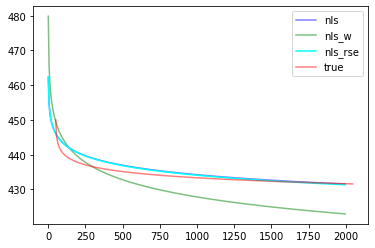

In [416]:
nlls = NLLS(power_law)
nlls.fit(x_samples, y_samples)
nlls_w = NLLS_w(power_law)
nlls_w.fit(x_samples, y_samples)
n_eval_steps = 2000
nlls_y = [nlls.f(x, **nlls.p) for x in range(1, n_eval_steps, 5)]
nlls_w_y = [nlls_w.f(x, **nlls_w.p) for x in range(1, n_eval_steps, 5)]


log_x_samples = [np.log(i) for i in x_samples]
log_y_samples = [np.log(i) for i in y_samples]
log_x_samples = sm.add_constant(log_x_samples)
result = sm.OLS(log_y_samples, log_x_samples, cov_type='HC0').fit()
result = result.get_robustcov_results('HC3')
params = result.params
print(params)
nls_rse_y = [linearized_power_law(x, params[1], params[0]) for x in range(1, n_eval_steps, 5)]

true_y = [power_law(x-50, a, b) for x in range(51, n_eval_steps+51, 5)]
x_eval = list(range(1, n_eval_steps, 5))
true_x_eval = list(range(51, n_eval_steps+51, 5))



plt.plot(x_eval, nlls_y, c='blue', alpha=.5, label='nls')
plt.plot(x_eval, nlls_w_y, c='g', alpha=.5, label='nls_w')
plt.plot(x_eval, nls_rse_y, c='cyan', alpha=1, label='nls_rse')
plt.plot(true_x_eval, true_y, c='r', alpha=.5, label='true')
plt.legend()
# fit NNLS
# fit NNLS_w
# fit NNLS_rse

In [421]:
p_vals = []
thresholds = list(range(1, n_steps, 5))
for t in thresholds:
    x_s_copy = x_samples.copy()
    y_s_copy = y_samples.copy()
    x_s_copy = np.array([x for x in x_s_copy if x > t])
    y_s_copy = np.array(y_s_copy[-len(x_s_copy):])
    if len(x_s_copy) > 30:
        print(len(x_s_copy))
        nlls_rse = NLLS_rse(linearized_power_law)
        sampled_idxs = np.random.choice(list(range(len(x_s_copy))), 100).astype(int)
        nlls_rse.fit(x_s_copy[sampled_idxs], y_s_copy[sampled_idxs])
        p_dict = nlls_rse.p
        p_dict['a_cov'] = nlls_rse.pcov[0]
        p_dict['b_cov'] = nlls_rse.pcov[1]
        p_dict['rsq'] = nlls_rse.rsq
        p_dict['rsq_adj'] = nlls_rse.rsq_adj
        p_dict['ll'] = nlls_rse.ll
        p_dict['aic'] = nlls_rse.aic
        p_dict['bic'] = nlls_rse.bic
        p_dict['f_pval'] = nlls_rse.f_pval
        p_dict['f_test'] = nlls_rse.f_test
        p_dict['t'] = t
        p_vals.append(p_dict)
p_vals = pd.DataFrame(p_vals)

59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31


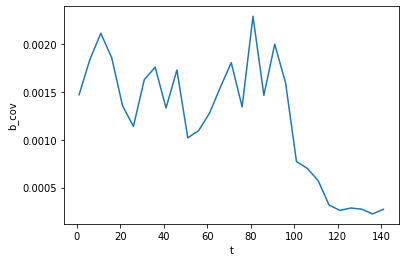

In [422]:
sns.lineplot(x='t', y='b_cov', data=p_vals)

In [524]:
ss = np.loadtxt('ss')
mses = np.loadtxt('mses')
n_eval_steps = max(ss)
x_samples = list(range(1, int(n_eval_steps), 5))
nlls = NLLS(power_law)
nlls.fit(ss, mses)
nlls_y = [nlls.f(x, **nlls.p) for x in x_samples]

nlls_w = NLLS_w(power_law)
nlls_w.fit(ss, mses)
nlls_w_y = [nlls_w.f(x, **nlls_w.p) for x in x_samples]

nlls_rse = NLLS_rse(linearized_power_law)
nlls_rse.fit(ss, mses)
nlls_rse_y = [nlls_rse.f(x, **nlls_w.p) for x in x_samples]

[[1.01450367e-12 3.99803326e-06]
 [3.99803326e-06 1.58515787e+01]]


/home/t-sdivya/.conda/envs/dm/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


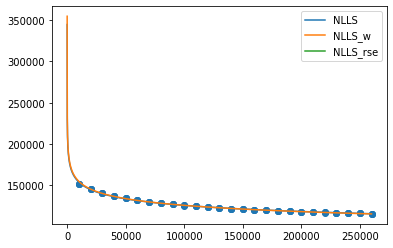

In [525]:
plt.scatter(ss, mses)
plt.plot(x_samples, nlls_y, label="NLLS")
plt.plot(x_samples, nlls_w_y, label="NLLS_w")
plt.plot(x_samples, nlls_rse_y, label="NLLS_rse")
plt.legend()

In [562]:
goal_pct = ".85"
goal_pct_float = float(goal_pct)
expmt = 'ml-20m-tiny_5_False_0.1_0.4_uniform_40000_30_1_1000000_10000_0.5_0.5_0_0' + goal_pct
data = pd.read_csv('./results/forecasting/' + expmt + '/results_df')
ax = sns.boxplot(x='curve_model', y='micro_pct', data=data)
plt.xlabel("Stopping criterion")
plt.ylabel("% of Total Global Performance")
plt.title("Global Goal of " + goal_pct + ": Performance of Stopping Criterion")
ax.axhline(y=goal_pct_float, c='r')

FileNotFoundError: [Errno 2] File ./results/forecasting/ml-20m-tiny_5_False_0.1_0.4_uniform_40000_30_1_1000000_10000_0.5_0.5_0_0.85/results_df does not exist: './results/forecasting/ml-20m-tiny_5_False_0.1_0.4_uniform_40000_30_1_1000000_10000_0.5_0.5_0_0.85/results_df'

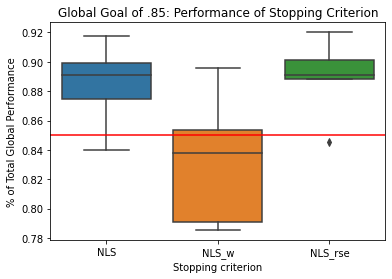

In [561]:
goal_pct = ".85"
goal_pct_float = float(goal_pct)
expmt = 'ml-20m-tiny_5_False_0.1_0.4_user_subset_1000_250_30_1_20000_0.5_0.5_0_0.85'
data = pd.read_csv('./results/forecasting/' + expmt + '/results_df')
ax = sns.boxplot(x='curve_model', y='micro_pct', data=data)
plt.xlabel("Stopping criterion")
plt.ylabel("% of Total Global Performance")
plt.title("Global Goal of " + goal_pct + ": Performance of Stopping Criterion")
ax.axhline(y=goal_pct_float, c='r')